Dataset shape: (1010, 2) (1010,)


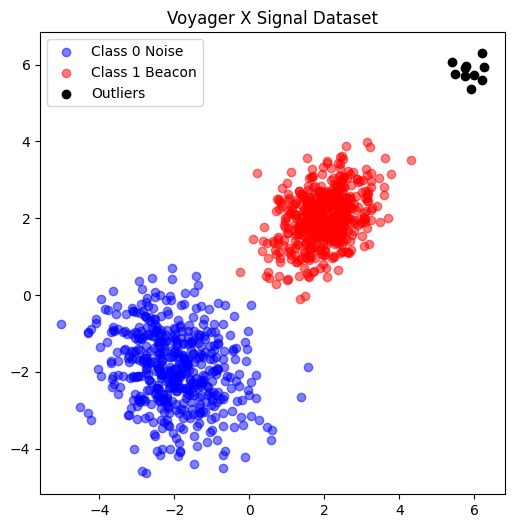

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ---------- Class parameters ----------
mu1 = np.array([2, 2])
Sigma1 = np.array([[0.5, 0.2],
                   [0.2, 0.5]])

mu0 = np.array([-2, -2])
Sigma0 = np.array([[1.0, -0.3],
                   [-0.3, 1.0]])

# Outliers
mu_out = np.array([6, 6])
Sigma_out = 0.1 * np.eye(2)

# ---------- Sampling ----------
X1 = np.random.multivariate_normal(mu1, Sigma1, 500)   # class 1
X0 = np.random.multivariate_normal(mu0, Sigma0, 500)   # class 0
X_out = np.random.multivariate_normal(mu_out, Sigma_out, 10)

# Attach labels
y1 = np.ones(500)
y0 = np.zeros(500)
y_out = np.zeros(10)

# Combine
X = np.vstack([X1, X0, X_out])
y = np.hstack([y1, y0, y_out])

print("Dataset shape:", X.shape, y.shape)

# ---------- Visualization ----------
plt.figure(figsize=(6,6))
plt.scatter(X0[:,0], X0[:,1], color='blue', alpha=0.5, label="Class 0 Noise")
plt.scatter(X1[:,0], X1[:,1], color='red', alpha=0.5, label="Class 1 Beacon")
plt.scatter(X_out[:,0], X_out[:,1], color='black', label="Outliers")
plt.title("Voyager X Signal Dataset")
plt.legend()
plt.show()


In [2]:
# ----- feature map with bias -----
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

Phi = add_bias(X)

# Closed-form solution: W = (ΦᵀΦ)^(-1) Φᵀ t
W_ls = np.linalg.inv(Phi.T @ Phi) @ (Phi.T @ y)

# prediction
def predict_ls(Xtest):
    return (add_bias(Xtest) @ W_ls >= 0.5).astype(int)

y_pred_ls = predict_ls(X)

print("Least Squares accuracy:", np.mean(y_pred_ls == y))

Least Squares accuracy: 0.9900990099009901


In [3]:
# Separate class data
X0_all = X[y==0]
X1_all = X[y==1]

# Means
mu0_hat = np.mean(X0_all, axis=0)
mu1_hat = np.mean(X1_all, axis=0)

# Shared covariance
Sigma_pooled = ((X0_all - mu0_hat).T @ (X0_all - mu0_hat) +
                (X1_all - mu1_hat).T @ (X1_all - mu1_hat)) / (len(X)-2)

# Prior
pi1 = np.mean(y)
pi0 = 1 - pi1

# Discriminant score
def predict_lda(Xtest):
    invS = np.linalg.inv(Sigma_pooled)
    score = Xtest @ invS @ (mu1_hat - mu0_hat) \
            - 0.5*(mu1_hat.T @ invS @ mu1_hat - mu0_hat.T @ invS @ mu0_hat) \
            + np.log(pi1/pi0)
    return (score >= 0).astype(int)

y_pred_lda = predict_lda(X)
print("LDA accuracy:", np.mean(y_pred_lda == y))

LDA accuracy: 0.9900990099009901


In [4]:
# Class covariances
Sigma0_hat = np.cov(X0_all.T)
Sigma1_hat = np.cov(X1_all.T)

def log_gaussian(x, mu, Sigma):
    d = x.shape[-1]
    return -0.5*np.log(np.linalg.det(Sigma)) \
           -0.5*(x-mu) @ np.linalg.inv(Sigma) @ (x-mu).T \
           - d/2*np.log(2*np.pi)

def predict_qda(Xtest):
    preds=[]
    for x in Xtest:
        g0 = log_gaussian(x, mu0_hat, Sigma0_hat) + np.log(pi0)
        g1 = log_gaussian(x, mu1_hat, Sigma1_hat) + np.log(pi1)
        preds.append(int(g1>=g0))
    return np.array(preds)

y_pred_qda = predict_qda(X)
print("QDA accuracy:", np.mean(y_pred_qda == y))

QDA accuracy: 0.9930693069306931


In [5]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X, y)
y_pred_lr = logreg.predict(X)

print("Logistic Regression accuracy:", np.mean(y_pred_lr == y))

Logistic Regression accuracy: 0.9891089108910891


In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Example using Logistic Regression probabilities
y_prob = logreg.predict_proba(X)[:,1]

cost_FN = 100  # beacon missed
cost_FP = 1    # noise called beacon

thresholds = np.linspace(0,1,100)
expected_loss = []

for th in thresholds:
    y_dec = (y_prob >= th).astype(int)
    cm = confusion_matrix(y, y_dec)
    FP = cm[0,1]
    FN = cm[1,0]
    loss = cost_FN*FN + cost_FP*FP
    expected_loss.append(loss)

optimal_th = thresholds[np.argmin(expected_loss)]
print("Optimal threshold under cost:", optimal_th)

Optimal threshold under cost: 0.37373737373737376
